In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import datetime as dt

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

## Target Variable

In [2]:
# 1. Read in the data from a CSV file and parse string data into date format for feature engineering.
# 2. Engineer the target variable by calculating the date 30 days prior to the last ride in the dataset 
# and classifying every rider who has not ridden in the past 30 days as churned.

df = pd.read_csv('data/churn.csv', parse_dates=[5, 7])
cutoff = df.last_trip_date.max() - dt.timedelta(days=30)
df['churn'] = df.apply(lambda x: 0 if x.last_trip_date > cutoff else 1, axis=1)

## Exploratory Data Analysis

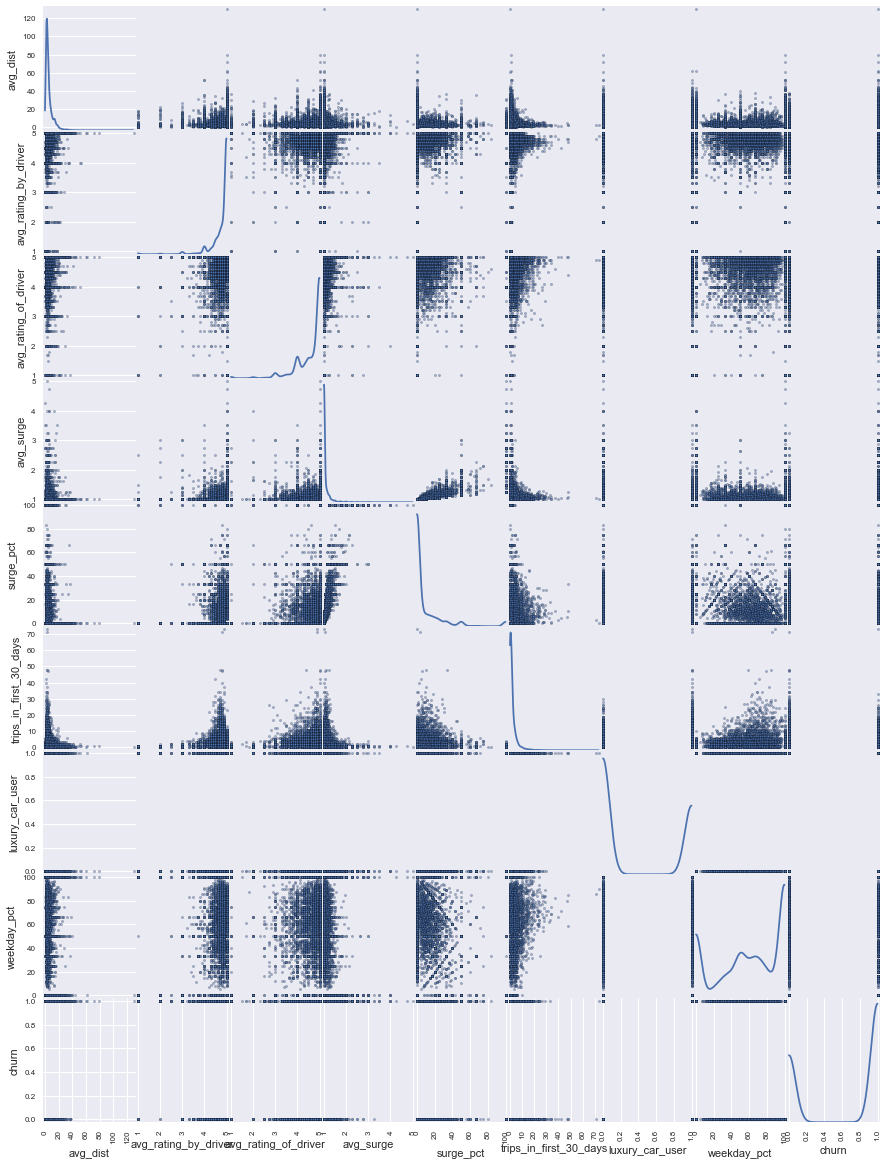

In [3]:
# I like to start by running a scatter matrix comparison on the data to find initial correlations between 
# inputs and the target variable. While there are no very pronounced trends visible by first glance, there seems to 
# be a slight 

pd.scatter_matrix(df[:10000], figsize=(15, 20), diagonal='kde');

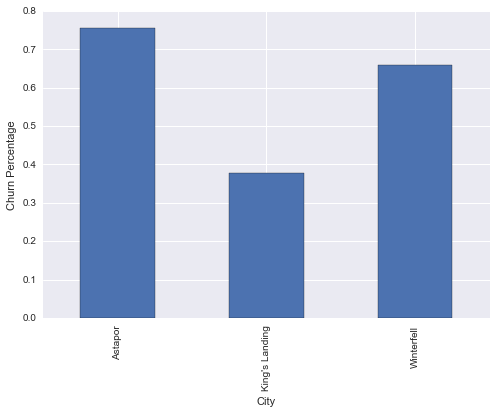

In [4]:
# It also helps to explore some categorical variables that are not represented in the scatter matrix plot. Here 
# it is easy to see that the churn rates vary across different cities. Users in Astapor are very likely to churn,
# while suers in King's Landing show much lower rates of churn.

df.groupby('city').churn.mean().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Churn Percentage');

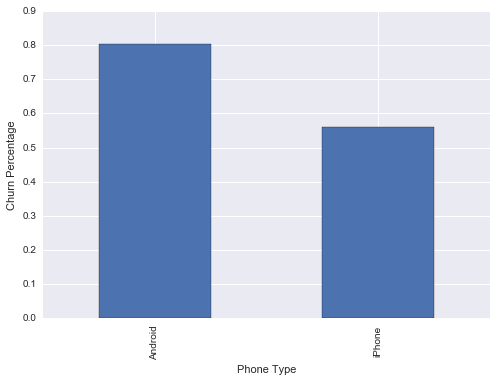

In [5]:
# Churn rates are different by different phone types--Android users show much higher likelihood of churning. 
# Android users due tend to be in lower socioeconomic areas (at least as of a report a couple years ago--Android phones
# are on average cheaper) and potentially the service is lower in these areas. 

df.groupby('phone').churn.mean().plot(kind='bar')
plt.xlabel('Phone Type')
plt.ylabel('Churn Percentage');

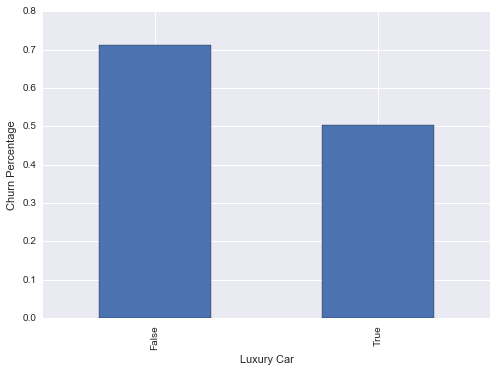

In [6]:
# Churn rates are also lower among luxury car users. One potential theory is that these users are less price sensitive, 
# and as such they are more likely to use the ridesharing service frequently.

df.groupby('luxury_car_user').churn.mean().plot(kind='bar')
plt.xlabel('Luxury Car')
plt.ylabel('Churn Percentage');

## Logistic Regression

Logistic Regression is a useful model to employ for churn classification, because, similar to linear regression, we are able to interpret the model coefficients' effect on the target variable (after converting them to an odds-ratio figure). From a business perspective, this can inform our actions to allocate resources efficiently to counter churn--for instance create marketing offers targeting certain segments of the customer base based on which attributes of that user (in a certain city, non-luxury car user).

In [7]:
# Generate dummy variables for categorical columns
df = pd.get_dummies(df, columns=['city'], drop_first=True)
df = pd.get_dummies(df, columns=['phone'], drop_first=True, dummy_na=True)

#After testing the hypothesis that categorizing and dummifying the rating would be indicative of churn, it turns out 
# to be true. Here these features are engineered.
df['avg_rating_of_driver'] = df.avg_rating_of_driver.round()
df = pd.get_dummies(df, columns=['avg_rating_of_driver'], drop_first=False, dummy_na=True)
df['avg_rating_by_driver'] = df.avg_rating_by_driver.round()
df = pd.get_dummies(df, columns=['avg_rating_by_driver'], drop_first=False, dummy_na=True)

In [8]:
#Drop all null values
df = df.dropna()

In [9]:
# Isolate target and input matricies
X = df.drop(['churn', 'last_trip_date', 'signup_date'], axis=1)
y = df['churn'].values

In [10]:
# Cross validate logistic regression with accuracy as scoring metric
lr = LogisticRegression(max_iter=200)
cross_val_score(lr, X, y, cv=10, scoring='accuracy', verbose=5)

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.732000 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.725800 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.733000 -   0.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.728800 -   0.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.730200 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.725200 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.728000 -   0.6s
[CV] n

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.0s finished


array([ 0.732 ,  0.7258,  0.733 ,  0.7288,  0.7302,  0.7252,  0.728 ,
        0.732 ,  0.7444,  0.7276])

In [11]:
# Cross validate logistic regression with recall as scoring metric. Recall is defined as 
# True Positives / (False Negatives + True Postives)
cross_val_score(lr, X, y, cv=10, scoring='recall', verbose=5)

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.867151 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.856422 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.862417 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.860208 -   0.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.858630 -   0.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.854844 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.856106 -   0.5s
[CV] n

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


array([ 0.86715052,  0.85642158,  0.86241717,  0.86020827,  0.85863048,
        0.8548438 ,  0.85610603,  0.85768381,  0.86525718,  0.85894604])

AUC: 0.78


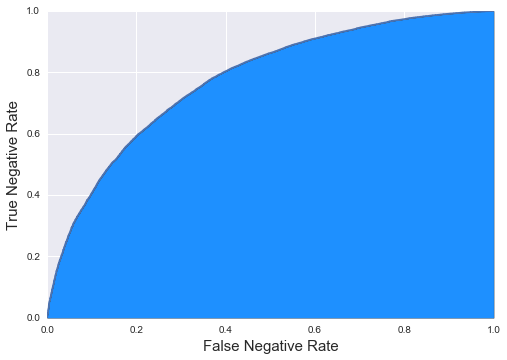

In [12]:
#Plotting the receiver operator curve helps visualize the perfomance of the classifier. The AUC of a perfect classifier
# will be 1.00, here we have an AUC of .78.

lr.fit(X, y)
preds = lr.predict_proba(X)[:,1]
fpr, tpr, thresh = roc_curve(y, preds)
auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.xlabel('False Negative Rate', fontsize=15)
plt.ylabel('True Negative Rate', fontsize=15);
plt.fill_between(fpr,tpr, facecolor='DodgerBlue');

print "AUC: {0:.2f}".format(round(auc,2))

In [13]:
# Create odds ratio interpretations of logistic beta coefficients
or_list = []
for coef in lr.coef_:
    or_list.append(np.exp(coef))
    
for col, score in zip(X.columns, or_list[0]):
    print "{:<25}:   {}".format(col, round(score, 3))

avg_dist                 :   1.034
avg_surge                :   1.164
surge_pct                :   0.996
trips_in_first_30_days   :   0.902
luxury_car_user          :   0.408
weekday_pct              :   0.999
city_King's Landing      :   0.171
city_Winterfell          :   0.578
phone_iPhone             :   0.321
phone_nan                :   0.588
avg_rating_of_driver_1.0 :   2.403
avg_rating_of_driver_2.0 :   1.62
avg_rating_of_driver_3.0 :   1.231
avg_rating_of_driver_4.0 :   0.91
avg_rating_of_driver_5.0 :   1.132
avg_rating_of_driver_nan :   2.123
avg_rating_by_driver_1.0 :   2.07
avg_rating_by_driver_2.0 :   2.247
avg_rating_by_driver_3.0 :   1.971
avg_rating_by_driver_4.0 :   0.738
avg_rating_by_driver_5.0 :   0.871
avg_rating_by_driver_nan :   1.779


### LR Conclusions

From the Logistic Regression model, we are able to achieve decent accuracy in classification (~73%)--with a higher recall (~86%). Recall is an important metric here. High recall means that false negatives are being minimized--the model is doing a good job of **not** classifying potential churners as non-churners. Assuming that the counteraction the company takes against customer churn is cheap, the company cares less about false positives--inidividuals who were not going to churn but are predicted by the model to churn--because in this case there is little downside to reaching out to these customers. (Depending on the cost of this marketing spend compared to the customer LTV, we would be able to determine an the profit maximizing threshold at which to set the model). 

## Gradient Boosting

Gradient boosting is considered one of the strongest supervised learning models given it's weak learner ensemble approach. GB iteratively updates it's prediction by learning from previous iterations of predictions and improving that prediction. A key downside to using the model is a company will lose input explanatory power. Where we can determine the extent to which inputs are affecting output with logistic regression, GB simply produces a prediction that we have to go with. If the model significantly improves predictive power, it can be useful for generating the final list of churners versus non-churners.

In [14]:
gb = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=200, 
                               subsample=1.0, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_depth=3, init=None, 
                               random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='auto')

cross_val_score(gb, X, y, cv=10, scoring='accuracy', verbose=5)

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.761000 -   9.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.770400 -   8.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.764000 -  10.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.760800 -   9.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.767600 -   8.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.763400 -   8.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.763800 -   8.3s
[CV] n

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


array([ 0.761 ,  0.7704,  0.764 ,  0.7608,  0.7676,  0.7634,  0.7638,
        0.7708,  0.7732,  0.7608])

## Conclusions

Based on the findings from the logistic regression, the company can conclude a couple takeaways regarding churn:

- Low ratings of drivers (no rating, 1 star, 2 stars) significantly increase the likelihood of churn. Similarly, low ratings of users by the driver also increase the likelihood of churn. This could be due to mutually poor experience. More research can be done to determine if there driver rating threshold on which to focus on (from our findings, maybe we could engage people rating drivers around a 2-3 to get them more happy with the service, whereas those with consistently 1 ratings are potentially already set on churning.)

- City matters: Astapoor users are very likely to churn, there should be a focus on improving retention in this city. 
- iPhone users retain much better than Android users:
    - this could be app experience
    - it could also be pricing schemes not matching for Android users; maybe we can determine some city/regional pricing improvements to make (Oakland versus San Francisco)
- Luxury car users appear content with the service 

The logistic regression model is much more useful for the purposes of being able to see which predictors are most important for churn prediction. Using a gradient boosted classifier only marginally improved accuracy of prediction, while not providing an equal amount of input interpretablity.